cf. https://otexts.com/fpp2/stationarity.html

In [45]:
%load_ext autoreload
%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from datetime import date

from src.data.news import get_regional_count_df
from src.data.news.sources.mediacloud import unavailability

df = get_regional_count_df(
    "klima*",
    "Berlin",
    date(2019, 1, 1),
    date(2022, 12, 30),
    source="mediacloud",
)
# df = df[(df["date"].dt.date <= unavailability["start"]) | (df["date"].dt.date >= unavailability["end"])]

## Time series

### Nonstationary time series

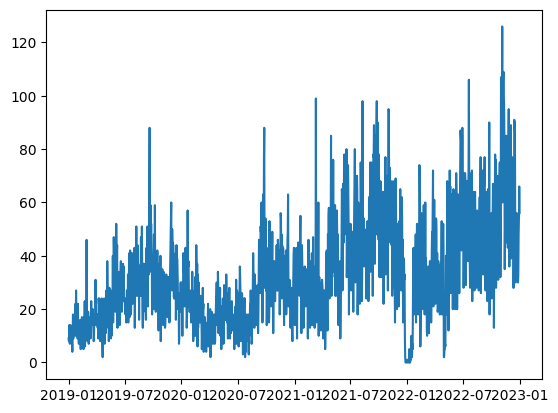

In [47]:
import matplotlib.pyplot as plt

plt.plot(df["date"], df["count"])

### Time series with stable variance

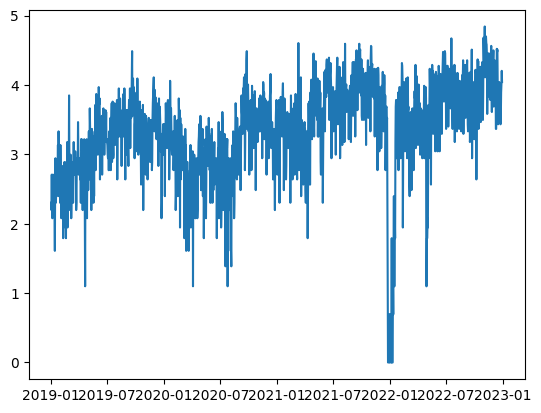

In [48]:
import numpy as np

plt.plot(df["date"], np.log(df["count"] + 1))

### Time series with stable mean

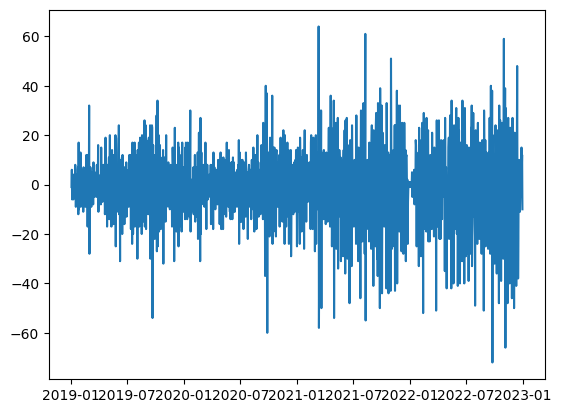

In [49]:
plt.plot(df["date"], df["count"].diff())

### Stationary time series

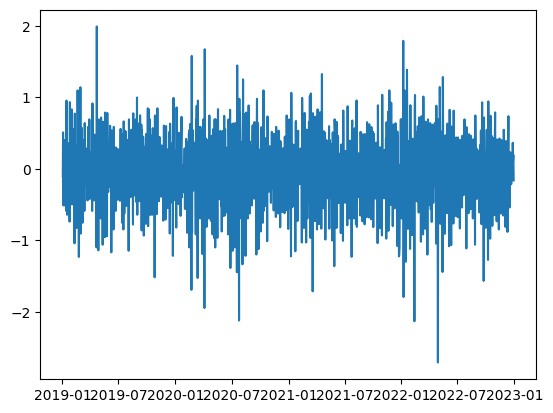

In [50]:
plt.plot(df["date"], np.log(df["count"] + 1).diff())

Now both mean and variance are stable.

## Histograms

### Nonstationary

<Axes: >

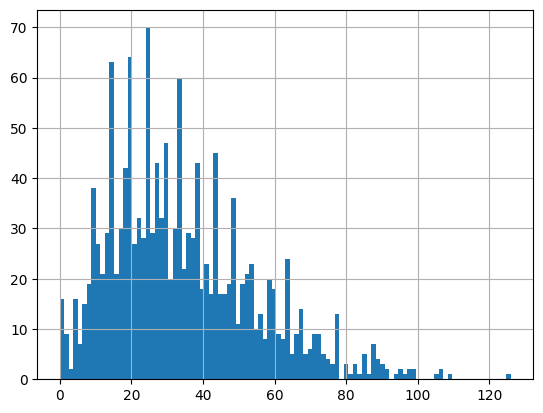

In [51]:
df["count"].hist(bins=100)

### Stable variance

<Axes: >

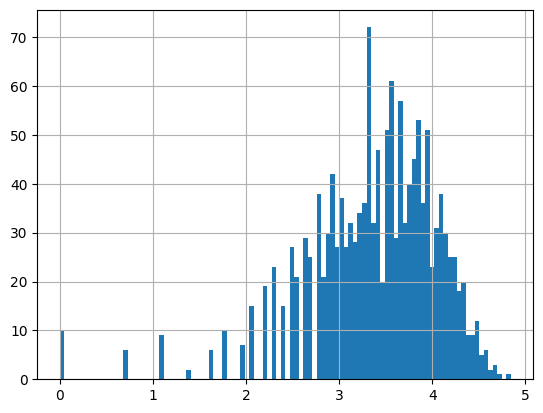

In [52]:
np.log(df["count"] + 1).hist(bins=100)

### Stable mean

<Axes: >

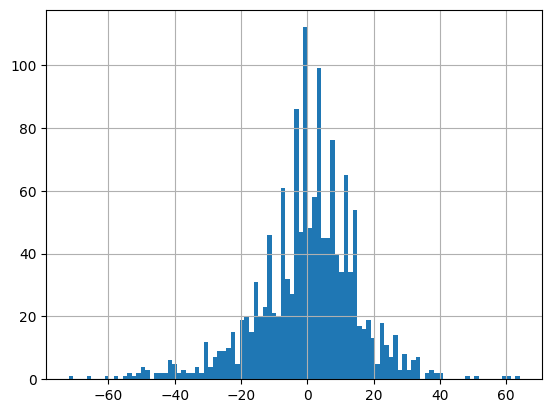

In [53]:
df["count"].diff().hist(bins=100)

In [54]:
df["count"].diff().describe()

count    1459.000000
mean        0.032214
std        15.383963
min       -72.000000
25%        -7.000000
50%         1.000000
75%         9.000000
max        64.000000
Name: count, dtype: float64

### Stationary

<Axes: >

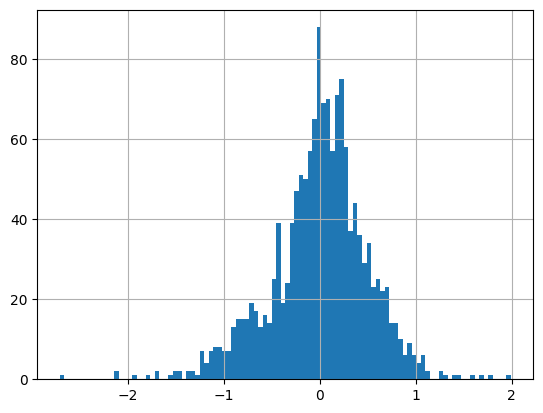

In [55]:
np.log(df["count"] + 1).diff().hist(bins=100)

In [56]:
np.log(df["count"] + 1).diff().describe()

count    1459.000000
mean        0.001193
std         0.498136
min        -2.708050
25%        -0.248257
50%         0.033523
75%         0.287682
max         1.992430
Name: count, dtype: float64

## Back and forth

In [57]:
def transform(x):
    return np.log(x + 1).diff().dropna(), x.iloc[0], x.iloc[-1]


def inverse_transform(x, start, end=None):
    start = np.array([start]) if not isinstance(start, np.ndarray) else start
    x = np.concatenate([np.log(start + 1), x])
    return np.exp(x.cumsum()) - 1


def inverse_transform_reverse(x, start=None, end=None):
    assert end is not None
    end = np.array([end]) if not isinstance(end, np.ndarray) else end
    x = np.concatenate([np.log(end + 1), -x[::-1]])
    return np.exp(x.cumsum())[::-1] - 1

In [58]:
df["count"] - inverse_transform(*transform(df["count"]))

0      -1.776357e-15
1      -1.776357e-15
2       0.000000e+00
3      -1.776357e-15
4       1.776357e-15
            ...     
1455    2.131628e-14
1456    4.973799e-14
1457    3.552714e-14
1458    8.526513e-14
1459    4.263256e-14
Name: count, Length: 1460, dtype: float64

In [59]:
df["count"] - inverse_transform_reverse(*transform(df["count"]))

0      -1.065814e-14
1      -8.881784e-15
2      -1.243450e-14
3      -8.881784e-15
4      -5.329071e-15
            ...     
1455   -7.105427e-15
1456    7.105427e-15
1457   -1.421085e-14
1458    2.842171e-14
1459   -7.105427e-15
Name: count, Length: 1460, dtype: float64

## Normality?

Perhaps the distributions are even normal after differencing?

In [60]:
# inspired by https://danielhnyk.cz/fitting-distribution-histogram-using-python/
from scipy import stats


def hist_with_dist(x, dist=stats.norm):
    hist, bin_edges = np.histogram(x, bins=100, density=True)
    hist = hist / sum(hist)
    plt.bar(bin_edges[:-1], hist, label="Hist")
    xt = plt.xticks()[0]
    xmin, xmax = min(xt), max(xt)
    lnspc = np.linspace(xmin, xmax, len(x))
    params = dist.fit(x)
    pdf_g = dist.pdf(lnspc, *params)
    plt.plot(lnspc, pdf_g, label="Norm", color="red")

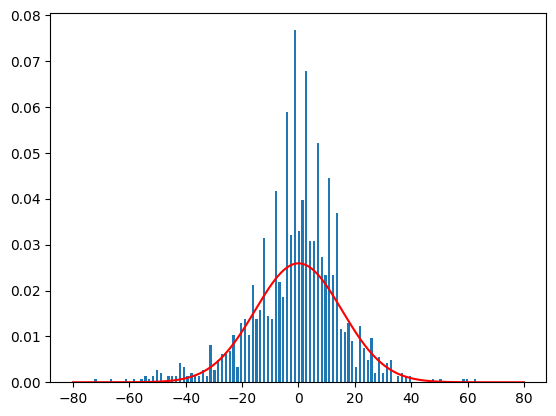

In [61]:
hist_with_dist(df["count"].diff().dropna())

In [62]:
stats.normaltest(df["count"].diff().dropna()).pvalue

9.168942514291405e-30

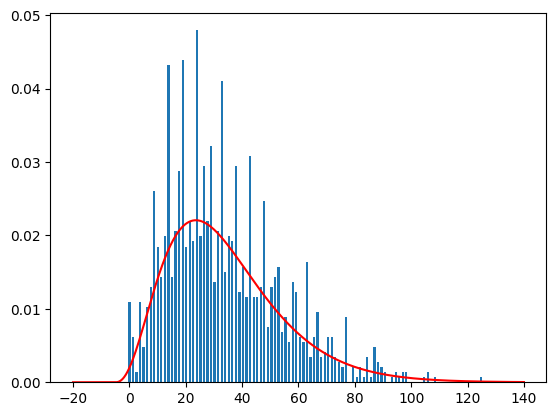

In [63]:
hist_with_dist(df["count"], dist=stats.gamma)

Bayern 2.8030163570499157e-16


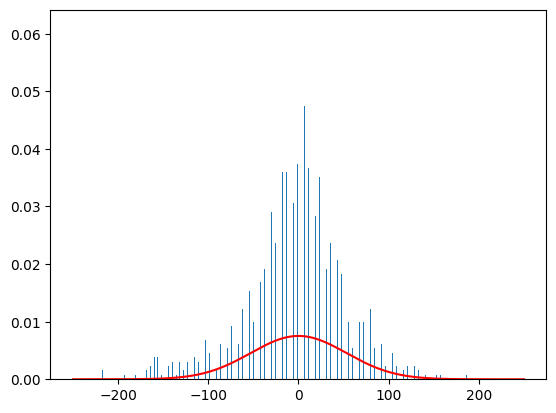

Berlin 5.8739654988244234e-27


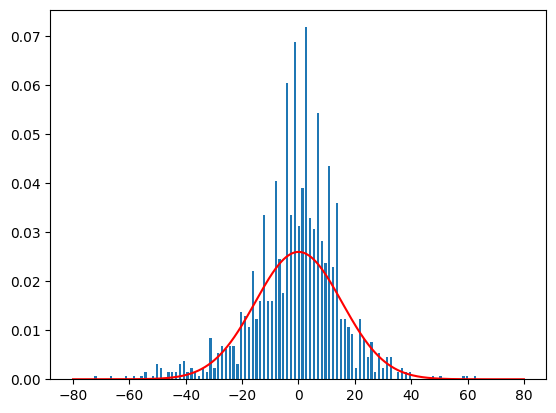

Brandenburg 1.3162526450835122e-46


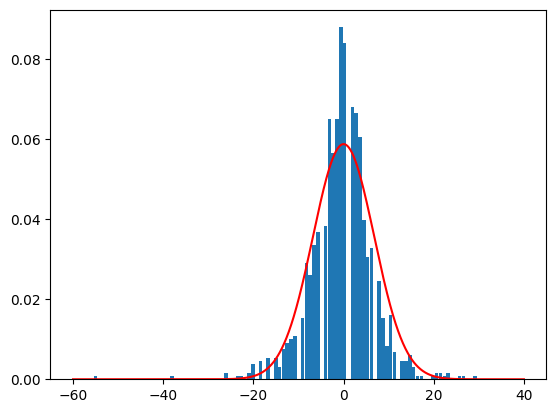

Bremen 1.4659868363768892e-28


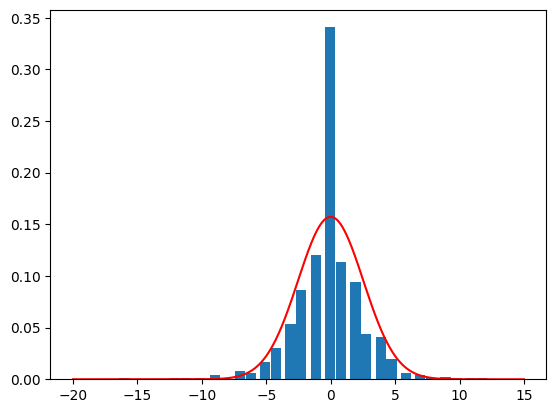

Hamburg 2.4141753916772173e-23


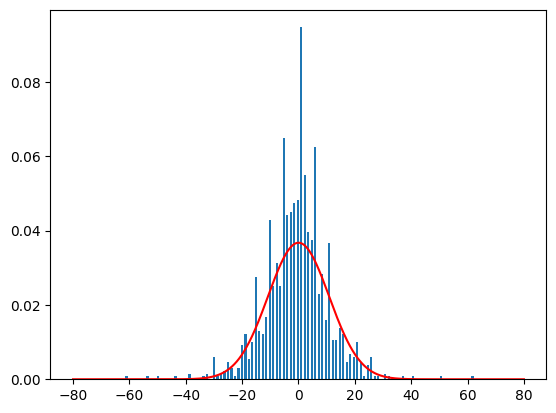

Hessen 0.00011255575514421805


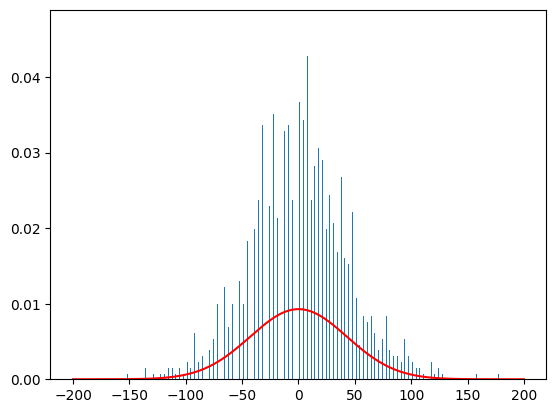

Niedersachsen 2.9725308254727036e-27


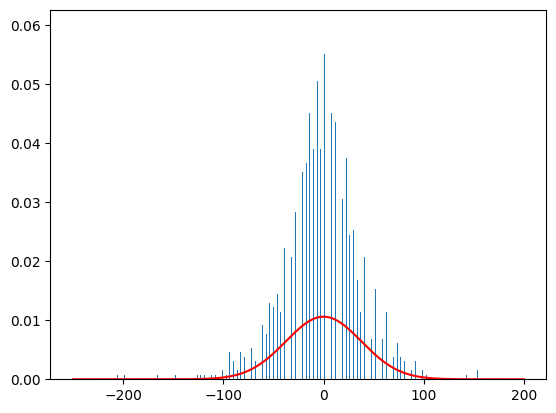

Nordrhein-Westfalen 1.0306034325815948e-16


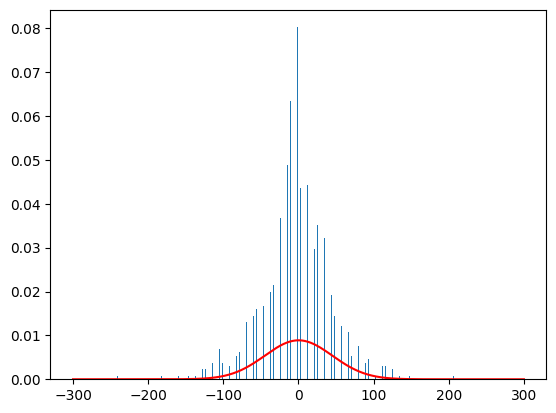

Rheinland-Pfalz 5.712318766986071e-08


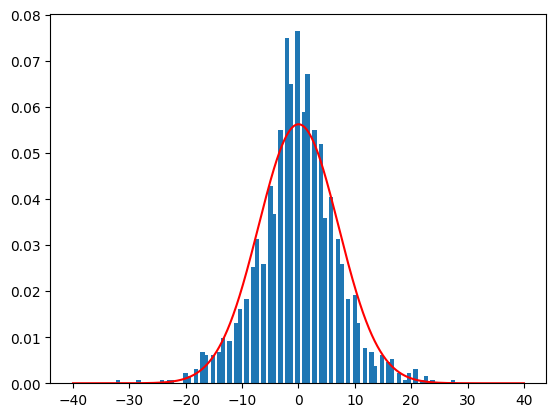

Saarland 0.00027501183550073546


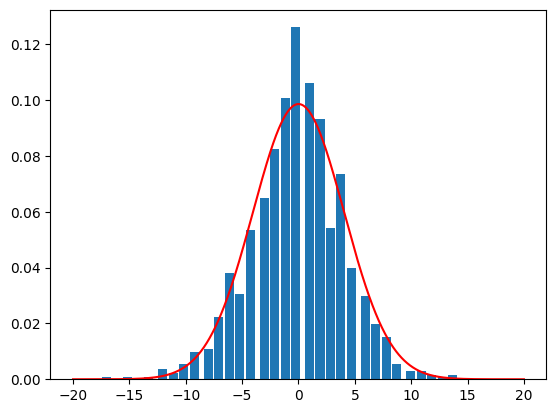

Sachsen 4.7008322989206586e-20


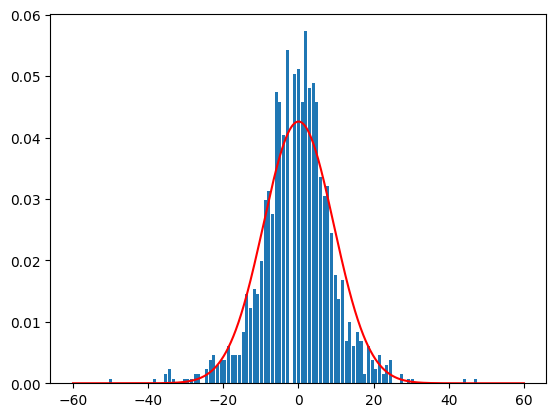

Sachsen-Anhalt 6.395717299769613e-17


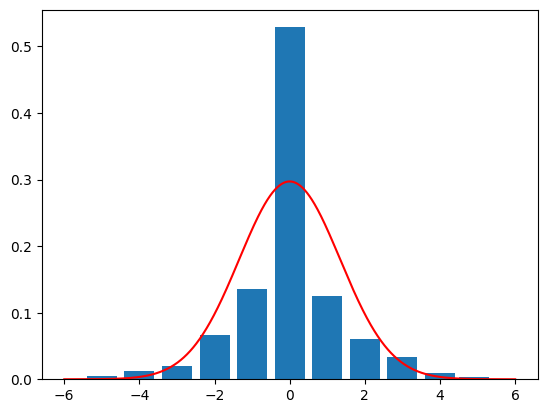

Schleswig-Holstein 2.9171566437633807e-32


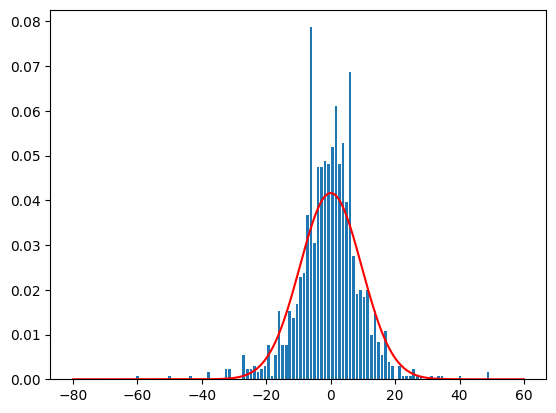

Thüringen 4.511842574019316e-30


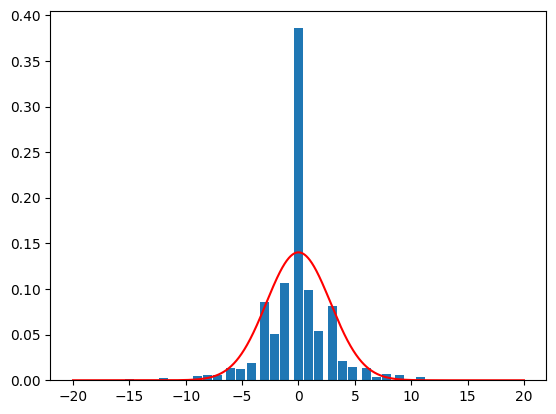

,region,pvalue
9,Saarland,2.750118e-04
5,Hessen,1.125558e-04
8,Rheinland-Pfalz,5.712319e-08
0,Bayern,2.803016e-16
7,Nordrhein-Westfalen,1.030603e-16
11,Sachsen-Anhalt,6.395717e-17
10,Sachsen,4.700832e-20
4,Hamburg,2.414175e-23
1,Berlin,5.873965e-27
6,Niedersachsen,2.972531e-27


In [64]:
import pandas as pd

from src.data import german_regions

results = []
for region in german_regions:
    df = get_regional_count_df(
        "klima*",
        region["name"],
        date(2019, 1, 1),
        date(2022, 12, 30),
        source="mediacloud",
    )
    if df is None:
        continue
    df = df[
        (df["date"].dt.date <= unavailability["start"])
        | (df["date"].dt.date >= unavailability["end"])
    ]
    pvalue = stats.normaltest(df["count"].diff().dropna()).pvalue
    print(region["name"], pvalue)
    hist_with_dist(df["count"].diff().dropna())
    plt.show()
    results.append(
        dict(
            region=region["name"],
            pvalue=pvalue,
        )
    )
pd.DataFrame(results).sort_values("pvalue", ascending=False)

They're not really normal, but roughly.

## Forecasting using the stationary data

In [65]:
from datetime import datetime

event = dict(
    event_date=datetime(2021, 6, 1),
    admin1="Berlin",
    size=1000,
)

In [66]:
from src.models.synthetic_region import (
    get_regional_counts_for_protest,
    predict_with_lasso,
    predict_with_linear_regression,
    synthetic_region,
    train_test_split,
)

df = get_regional_counts_for_protest(
    "klima*",
    event,
    pd.DataFrame([event]),
    source="mediacloud",
    n_days_train=7 * 4 * 6,
    n_days_predict=7 * 2,
    n_days_protest_free_pre=0,
    n_days_protest_free_post=0,
    min_control_regions=1,
    min_count=3,
)

In [67]:
metrics, _, count_df = synthetic_region(
    df, event, method=predict_with_linear_regression
)

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

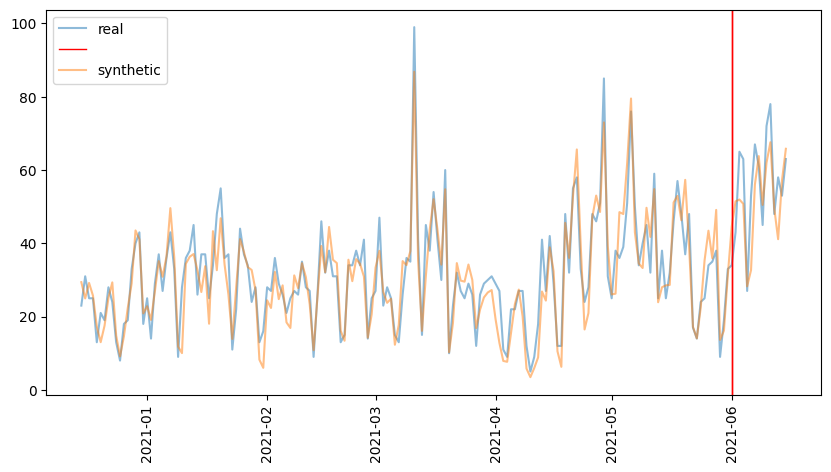

In [68]:
from src.data.discourse.visual import plot_comparison

plot_comparison(count_df, protest_date=event["event_date"])

In [69]:
import math


def train_test_split(df, protest_region, protest_date, normalize=False):
    """
    split and normalize

    df: df in pivoted form, with regions as columns and dates as index
    """
    split = df[df["date"].dt.date == protest_date].index[0]
    df = df.drop(columns=["date"])
    Y_height = df[protest_region].iloc[split]
    df, _, _ = transform(df)
    # normalize all columns using the mean of the training set
    if normalize:
        df = df / df.iloc[:split].mean()
        df = df.fillna(0)
        # replace infinities with 0
        df = df.replace([math.inf, -math.inf], 0)
    train = df.iloc[:split]
    test = df.iloc[split:]
    X_train = train.drop(columns=[protest_region])
    Y_train = train[protest_region]
    X_test = test.drop(columns=[protest_region])
    Y_test = test[protest_region]
    return X_train, Y_train, X_test, Y_test, Y_height

In [70]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error


def predict_with_model(df, protest_region, protest_date, model, normalize):
    """
    df: df in pivoted form, with regions as columns and dates as index
    """
    X_train, Y_train, X_test, Y_test, Y_height = train_test_split(
        df, protest_region, protest_date, normalize
    )
    model.fit(X_train, Y_train)
    Y_pred = inverse_transform(model.predict(X_test), start=Y_height)[1:]
    mse = mean_squared_error(Y_test, Y_pred)
    Y_back = inverse_transform_reverse(model.predict(X_train), end=Y_height)
    Y_pred_all = np.concatenate([Y_back, Y_pred])
    return mse, Y_pred_all, model

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


def predict_with_linear_regression_(
    df, protest_region, protest_date, normalize, positive=True
):
    assert normalize == False
    return predict_with_model(
        df,
        protest_region,
        protest_date,
        LinearRegression(fit_intercept=False, positive=positive),
        normalize,
    )


def predict_with_random_forest_(df, protest_region, protest_date, normalize):
    assert normalize == False
    return predict_with_model(
        df,
        protest_region,
        protest_date,
        RandomForestRegressor(),
        normalize,
    )

In [72]:
metrics, _, count_df = synthetic_region(
    df, event, method=predict_with_linear_regression_, normalize=False
)

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

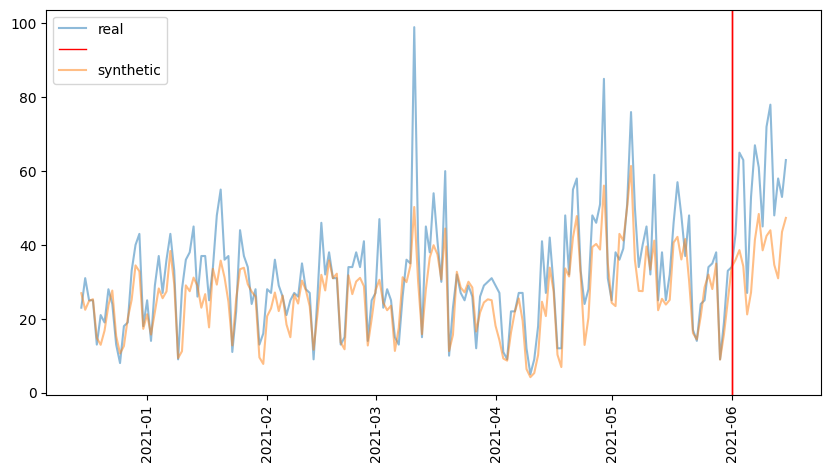

In [73]:
from src.data.discourse.visual import plot_comparison

plot_comparison(count_df, protest_date=event["event_date"])

## Comparisons

In [74]:
from src.data.protests.random import get_random_events
from src.models.synthetic_region import evaluate_multiple_protests


def evaluate(method, normalize):
    random_events = get_random_events(1000, seed=0)
    metrics, dfs, agg_df = evaluate_multiple_protests(
        "klima*",
        random_events,
        source="mediacloud",
        data_kwargs=dict(
            n_days_train=7 * 4 * 3,
            n_days_predict=7 * 4,
            n_days_protest_free_pre=0,
            n_days_protest_free_post=0,
            min_control_regions=1,
            min_count=3,
        ),
        method_kwargs=dict(
            method=method,
            normalize=normalize,
        ),
    )
    return metrics, dfs, agg_df

### Standard Lasso

In [75]:
from functools import partial

from src.models.synthetic_region import predict_with_lasso, predict_with_random_forest

_, _, agg_df = evaluate(predict_with_lasso, normalize=False)

  0%|          | 0/804 [00:00<?, ?it/s]

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

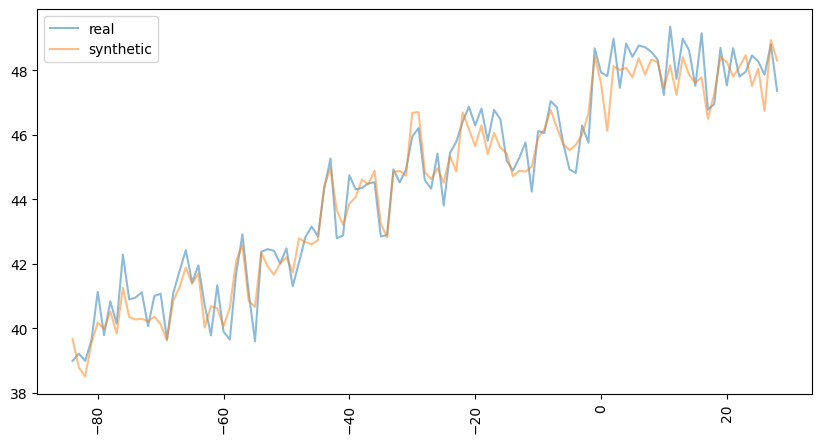

In [76]:
plot_comparison(agg_df)

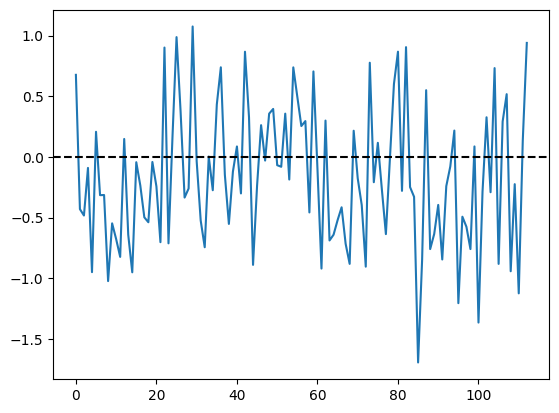

In [77]:
plt.plot(range(len(agg_df)), (agg_df["synth"] - agg_df["real"]), label="real")
plt.axhline(0, color="black", linestyle="--")

In [78]:
_, _, agg_df = evaluate(predict_with_lasso, normalize=True)

  0%|          | 0/804 [00:00<?, ?it/s]

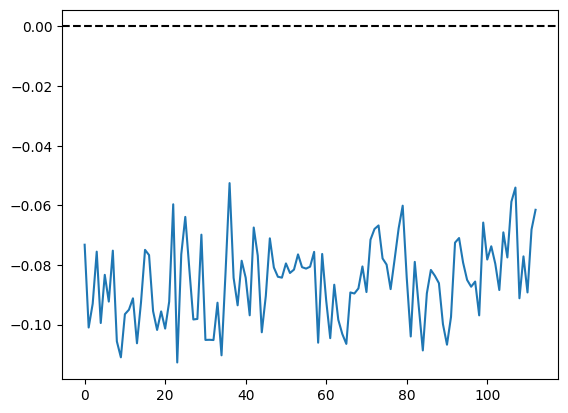

In [79]:
plt.plot(range(len(agg_df)), (agg_df["synth"] - agg_df["real"]), label="real")
plt.axhline(0, color="black", linestyle="--")

### Standard linear regression

In [80]:
_, _, agg_df = evaluate(predict_with_linear_regression, normalize=False)

  0%|          | 0/804 [00:00<?, ?it/s]

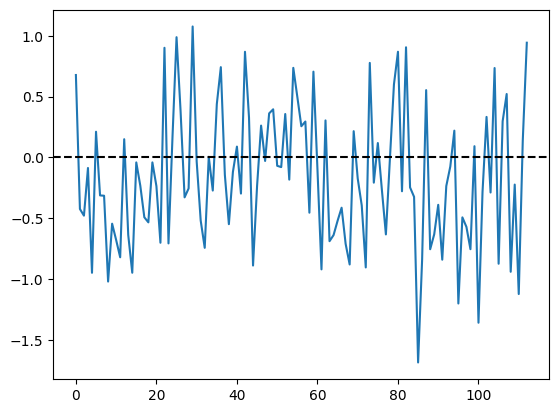

In [81]:
plt.plot(range(len(agg_df)), (agg_df["synth"] - agg_df["real"]), label="real")
plt.axhline(0, color="black", linestyle="--")

In [82]:
_, _, agg_df = evaluate(predict_with_lasso, normalize=True)

  0%|          | 0/804 [00:00<?, ?it/s]

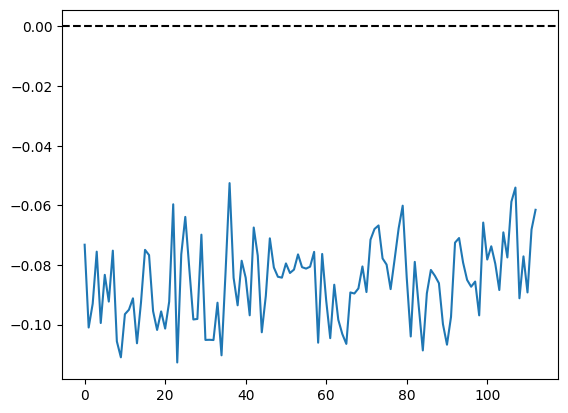

In [83]:
plt.plot(range(len(agg_df)), (agg_df["synth"] - agg_df["real"]), label="real")
plt.axhline(0, color="black", linestyle="--")

### Differenced linear regression

In [84]:
_, _, agg_df = evaluate(predict_with_linear_regression_, normalize=False)

  0%|          | 0/804 [00:00<?, ?it/s]

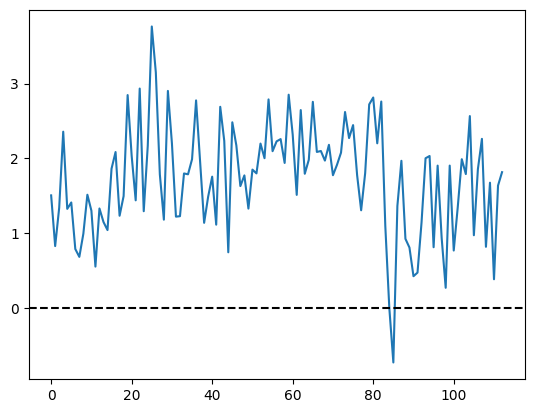

In [85]:
plt.plot(range(len(agg_df)), (agg_df["synth"] - agg_df["real"]), label="real")
plt.axhline(0, color="black", linestyle="--")

In [86]:
_, _, agg_df = evaluate(predict_with_linear_regression_, normalize=True)

  0%|          | 0/804 [00:00<?, ?it/s]

AssertionError: 

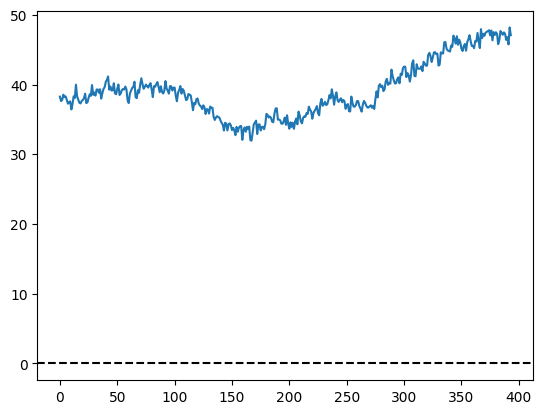

In [ ]:
plt.plot(range(len(agg_df)), (agg_df["synth"] - agg_df["real"]), label="real")
plt.axhline(0, color="black", linestyle="--")

### Differenced random forest

In [ ]:
_, _, agg_df = evaluate(predict_with_random_forest_, normalize=False)

  0%|          | 0/804 [00:00<?, ?it/s]

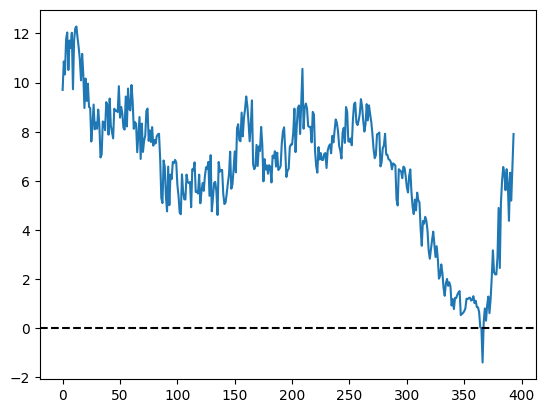

In [ ]:
plt.plot(range(len(agg_df)), (agg_df["synth"] - agg_df["real"]), label="real")
plt.axhline(0, color="black", linestyle="--")

In [ ]:
_, _, agg_df = evaluate(predict_with_random_forest_, normalize=True)

  0%|          | 0/804 [00:00<?, ?it/s]

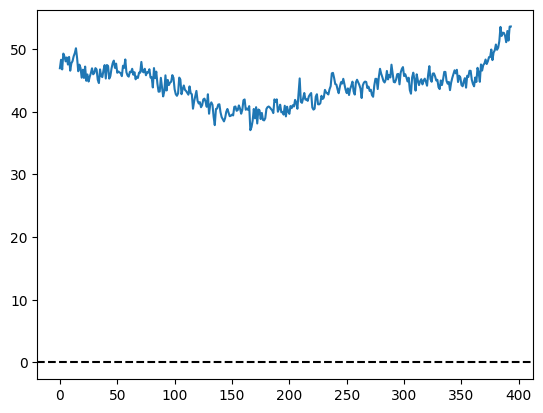

In [ ]:
plt.plot(range(len(agg_df)), (agg_df["synth"] - agg_df["real"]), label="real")
plt.axhline(0, color="black", linestyle="--")

So, all models are biased, and differencing only makes it worse.